In [1]:
import response_utils
from response_utils import brewer2_light
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import expm
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 2: Coupled 3 box model
## b) Spatially explicit forcing

### $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + \delta_{1,i} F(t)$
or
### $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + \gamma(x) F(t)$

In [2]:
# Grid parameters
dt = 1
Nt = 400 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
M_a = 1
M_s = 20
M_d = 380
lam_as = 0.2
lam_sd = 0.2
gamma = 1/2000
L = np.array([[-lam_as/M_a, lam_as/M_a, 0],
                [lam_as/M_s, -(lam_as + lam_sd)/M_s, lam_sd/M_s],
                [0, lam_sd/M_d, -lam_sd/M_d - gamma]])
T0 = 0 # K

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 0.4)
F_4xCO2 = response_utils.F_const(t, 0.8)

## RCP70
F_final = 1.4 # (W m^-2)
ts = 50
a_exp = F_final/np.exp(400*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 0.6
b_over = 200
c_over = 42.7
F_over = response_utils.F_over(t, a_over, b_over, c_over)

## Impulse forcing
F0 = 1
F_pulse = response_utils.F_del(t, F0)
F_del = {r'2xCO$_2$':F_pulse,
         r'4xCO$_2$':F_pulse,
         'High Emissions':F_pulse,
         'Overshoot':F_pulse}

## Compile all for diagnosis
F_all = {r'2xCO$_2$':F_2xCO2,
         r'4xCO$_2$':F_4xCO2,
         'High Emissions':F_exp,
         'Overshoot':F_over}

# Plotting parameters
experiments = [r'2xCO$_2$',r'4xCO$_2$','High Emissions','Overshoot']
regions = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
colors = ['g','r','b']

# Stochastic parameters
K = 0.5
N_ensemble = 50

# Generated perturbed ensemble
F_del_ensemble = response_utils.gen_F_ensemble(F_del, t, K, N_ensemble, experiments)
F_all_ensemble = response_utils.gen_F_ensemble(F_all, t, K, N_ensemble, experiments)

### Integrated solutions to experiments of interest

In [3]:
gamma = np.zeros((3))
gamma[0] = 1.0
G_opt = {}
for exp in experiments:
  # Assume the number of spatial points is the length of the gamma vector
  k = gamma.shape[0]
  lam, v = np.linalg.eig(L)
  w = np.linalg.pinv(v)

  G_opt[exp] = np.zeros((k, len(t)))

  for i, n in enumerate(t):
    # Create diagonal matrix of exp(lambda_i * t) for this particular time t
    exp_diag_trunc = np.diag(np.exp(lam * n))

    # Compute exp(L * t) using eigenvalue expansion: v * exp(diag(lambda) * t) * v^-1
    exp_Lt_trunc = v @ exp_diag_trunc @ w

    # Compute G(x, t) by multiplying exp(L * t) with gamma
    G_opt[exp][:, i] = np.dot(exp_Lt_trunc, gamma)

In [18]:
gamma = np.zeros((3))
gamma[0] = 1.0
G_L = {}
for exp in experiments:
  # Assume the number of spatial points is the length of the gamma vector
  k = gamma.shape[0]
  lam, v = np.linalg.eig(L_raw[exp])
  w = np.linalg.pinv(v)

  G_L[exp] = np.zeros((k, len(t)))

  for i, n in enumerate(t):
    # Create diagonal matrix of exp(lambda_i * t) for this particular time t
    exp_diag_trunc = np.diag(np.exp(lam * n))

    # Compute exp(L * t) using eigenvalue expansion: v * exp(diag(lambda) * t) * v^-1
    exp_Lt_trunc = v @ exp_diag_trunc @ w

    # Compute G(x, t) by multiplying exp(L * t) with gamma
    G_L[exp][:, i] = np.dot(exp_Lt_trunc, gamma)

/var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/ipykernel_93702/258575425.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  G_L[exp][:, i] = np.dot(exp_Lt_trunc, gamma)


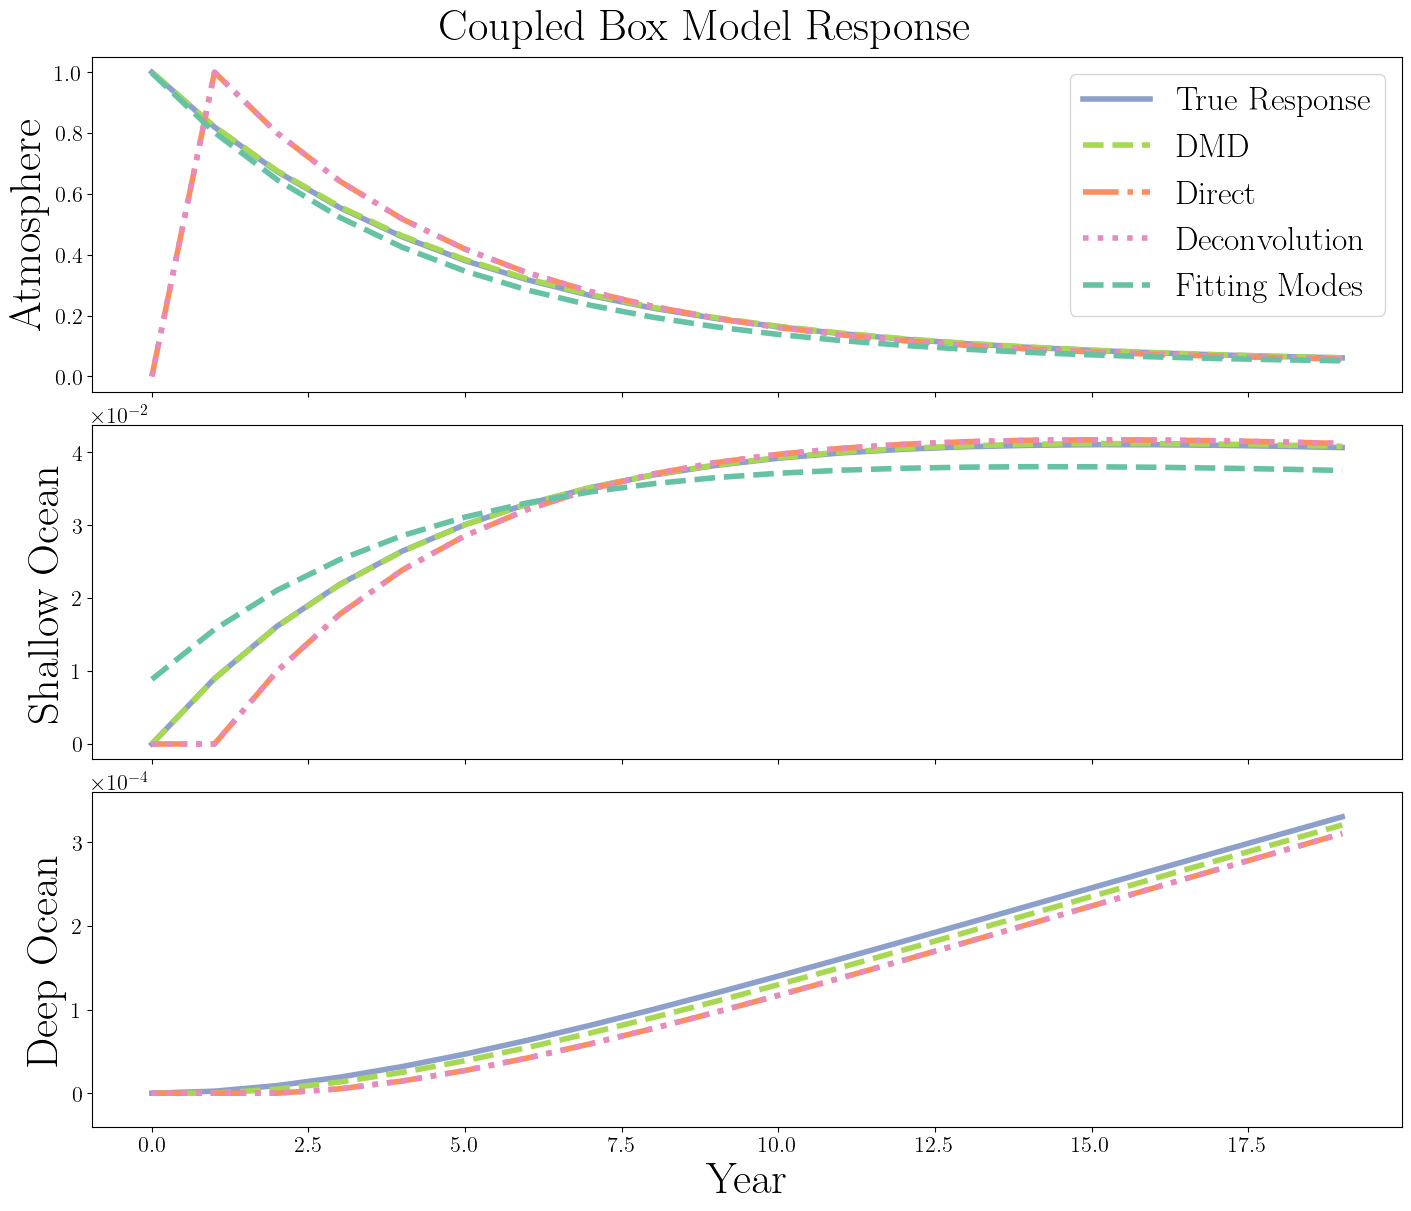

In [53]:
fig, ax = plt.subplots(3,1, figsize=(14,12), sharex=True, constrained_layout=True)

from matplotlib.ticker import ScalarFormatter

exp = '4xCO2'

i = 0
ax[i].plot(G_opt[exp][i][0:20], lw=4, label='True Response', c=brewer2_light(2))
ax[i].plot(G_L[exp][i][0:20], lw=4, ls='--', label='DMD', c=brewer2_light(4))
ax[i].plot(G_direct[exp][i][0:20], lw=4, ls='-.', label='Direct', c=brewer2_light(1))
ax[i].plot(G_deconv[exp][i][0][0:20], lw=4, ls=':',label='Deconvolution', c=brewer2_light(3))
ax[i].plot(G_fit[exp][i][0:20], lw=4, ls='--',label='Fitting Modes', c=brewer2_light(0))
ax[i].legend(fontsize=24)
ax[i].set_ylabel('Atmosphere',fontsize=32)

i = 1
ax[i].plot(G_opt[exp][i][0:20], lw=4, label='True Response', c=brewer2_light(2))
ax[i].plot(G_L[exp][i][0:20], lw=4, ls='--', label='DMD', c=brewer2_light(4))
ax[i].plot(G_direct[exp][i][0:20], lw=4, ls='-.', label='Direct', c=brewer2_light(1))
ax[i].plot(G_deconv[exp][i][0][0:20], lw=4, ls=':',label='Deconvolution', c=brewer2_light(3))
ax[i].plot(G_fit[exp][i][0:20], lw=4, ls='--',label='Fitting Modes', c=brewer2_light(0))
ax[i].set_ylabel('Shallow Ocean',fontsize=32)

i=2
ax[i].plot(G_opt[exp][i][0:20], lw=4, label='True Response', c=brewer2_light(2))
ax[i].plot(G_L[exp][i][0:20], lw=4, ls='--', label='DMD', c=brewer2_light(4))
ax[i].plot(G_direct[exp][i][0:20], lw=4, ls='-.', label='Direct', c=brewer2_light(1))
ax[i].plot(G_deconv[exp][i][0][0:20], lw=4, ls=':',label='Deconvolution', c=brewer2_light(3))
#ax[i].plot(G_fit[exp][i][0:20], lw=4, ls='--',label='Fitting Modes', c=brewer2_light(0))
ax[i].set_ylabel('Deep Ocean',fontsize=32)
ax[i].set_ylim([-0.00004,0.00036])
ax[i].set_xlabel('Year',fontsize=32)

fig.suptitle('Coupled Box Model Response',fontsize=32)

for a in ax:
  a.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
  a.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.savefig('fig1.pdf',dpi=500)

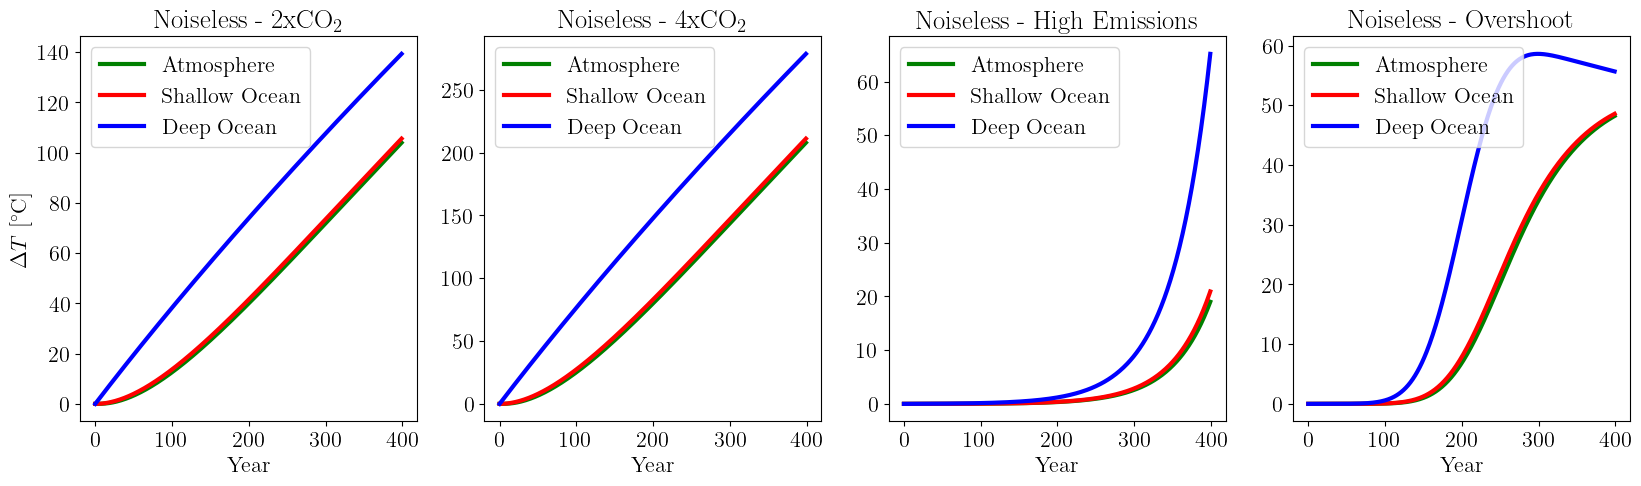

In [5]:
gamma = np.zeros((3))
gamma[0] = 1.0

gamma_2 = np.zeros((3))
gamma_2[1] = 1.0

gamma_3 = np.zeros((3))
gamma_3[2] = 1.0

T_analytic, g_analytic, a_analytic = response_utils.timestep_coup(t, experiments, F_all, L, dt, gamma=gamma)
T_analytic_2, g_analytic, a_analytic = response_utils.timestep_coup(t, experiments, F_all, L, dt, gamma=gamma_2)
T_analytic_3, g_analytic, a_analytic = response_utils.timestep_coup(t, experiments, F_all, L, dt, gamma=gamma_3)
response_utils.plot_box_model(T_analytic_3, t, experiments, regions, colors, soln_type='Noiseless', coupled=True)
#response_utils.plot_box_model2(T_analytic_2, t, experiments, regions, colors, soln_type='Noiseless', coupled=True, T2=T_est_raw_3)
#response_utils.plot_box_model2(T_analytic_2, t, experiments, regions, colors, soln_type='Noiseless', coupled=True)
#response_utils.plot_box_model2(T_analytic_3, t, experiments, regions, colors, soln_type='Noiseless', coupled=True)

#### Method 1: Direct derivation of Green's function

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP70: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



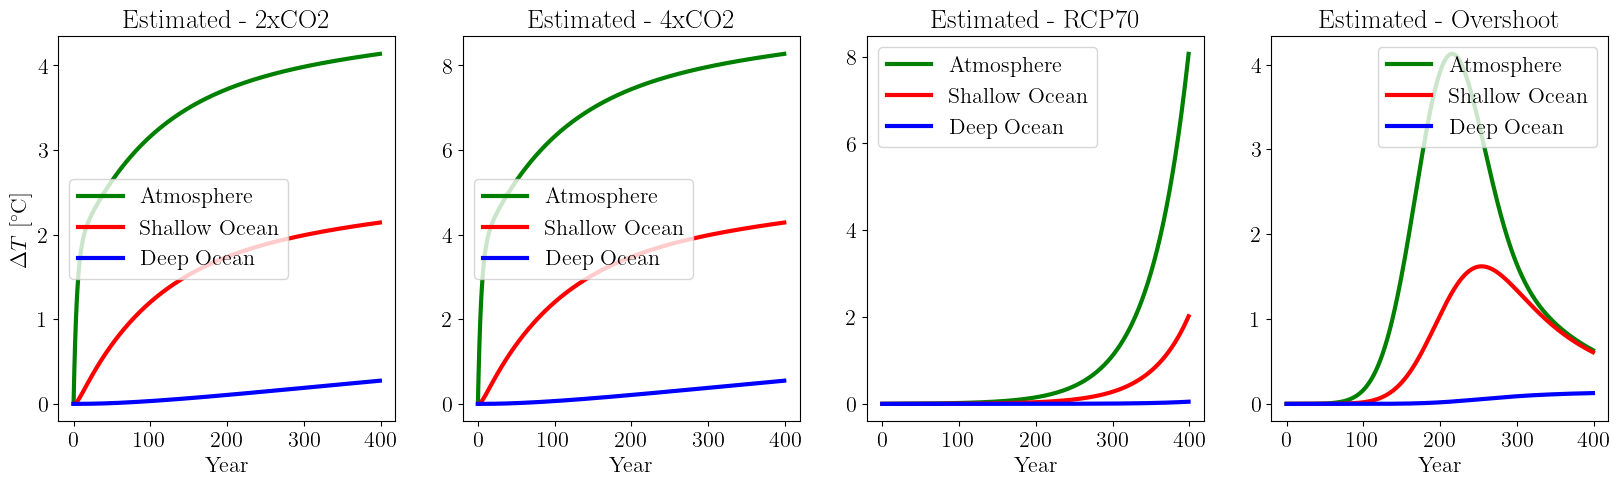

In [5]:
G_direct, g_direct, a_direct = response_utils.timestep_coup(t, experiments, F_del, L, dt, gamma=gamma)

T_est_raw_1, T_est_modal_1 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_direct, a_direct,
                                                      g_direct, T0, dt)

response_utils.plot_box_model(T_est_raw_1, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_1, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_1 = response_utils.calc_L2(T_analytic, T_est_raw_1, experiments, regions, 'Raw', coupled=True)
#L2_modal_1 = response_utils.calc_L2(T_analytic, T_est_modal_1, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 2: Direct inference of L from a dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO$_2$: 0.12119
	L2 Error, 4xCO$_2$: 0.24238
	L2 Error, High Emissions: 0.1415
	L2 Error, Overshoot: 0.10704
Avg. L2 Error: 0.15303



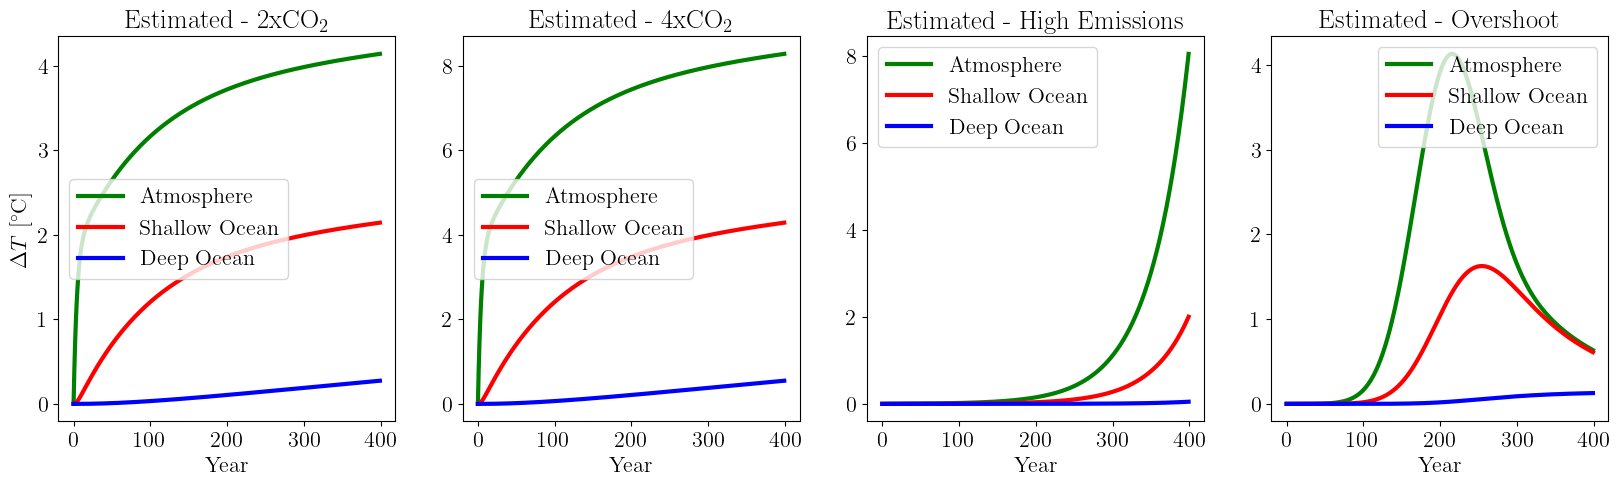

In [22]:
L_raw, L_modal = {}, {}
gamma = np.zeros((3))
gamma[0] = 1.0
for exp in experiments:
  L_raw[exp] = response_utils.calc_L_direct_2D(T_analytic[exp], F_all[exp], t, gamma=gamma)
  L_modal[exp] = response_utils.calc_L_direct_2D(a_analytic[exp], F_all[exp], t, gamma=gamma, modal=True, g=g_analytic[exp])

T_est_raw_2, T_est_modal_2 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'L',
                                                      L_raw, L_modal, None,
                                                      T0, dt, gamma)

response_utils.plot_box_model(T_est_raw_2, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_2, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_2 = response_utils.calc_L2(T_analytic, T_est_raw_2, experiments, regions, 'Raw', coupled=True)
#L2_modal_2 = response_utils.calc_L2(T_analytic, T_est_modal_2, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 3: Direct deconvolution of response function from dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO$_2$: 0.0
	L2 Error, 4xCO$_2$: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



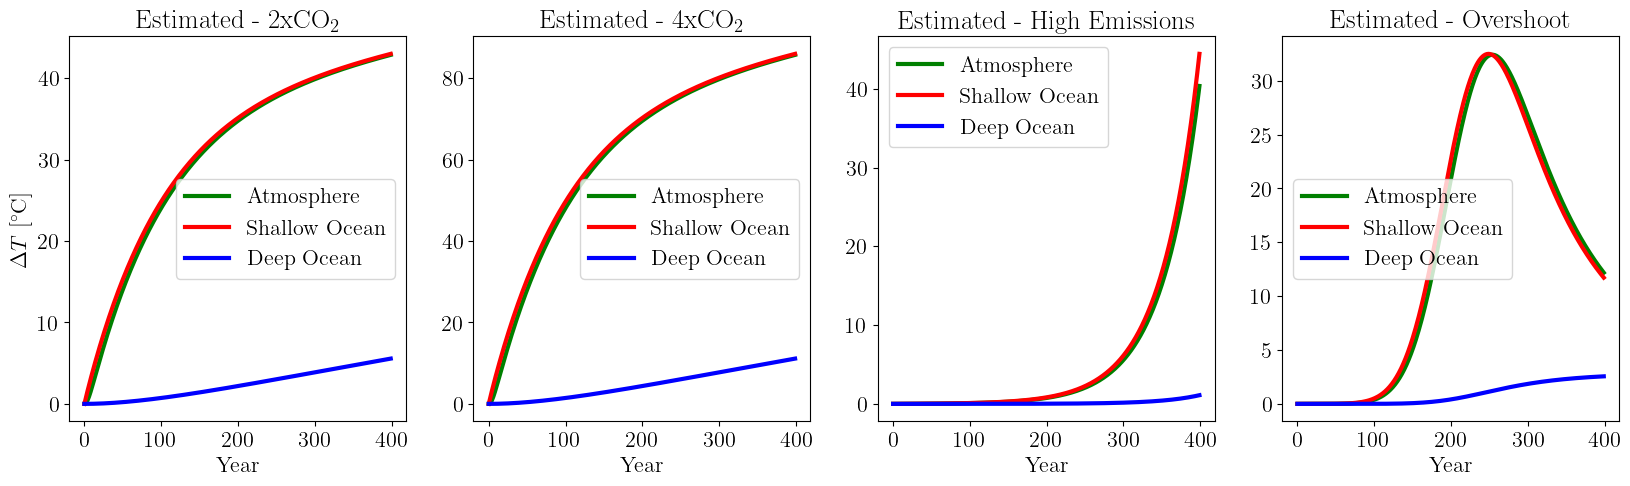

In [70]:
G_deconv = {}
#g_deconv, a_deconv = {}, {}
gamma = np.zeros((3))
gamma[0] = 1.0
for exp in experiments:
  G_deconv[exp] = []
  for i, reg in enumerate(regions):
    G_deconv[exp].append(response_utils.calc_G_deconv_2D(T_analytic_2[exp][i], F_all[exp], dt=1, gamma=gamma_2))
    #g_deconv[exp], a_deconv[exp] = response_utils.calc_modes_2D(G_deconv[exp])

T_est_raw_3, T_est_modal_3 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_deconv, None,
                                                      None, T0, dt, gamma_2)

response_utils.plot_box_model(T_est_raw_3, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_3, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_3 = response_utils.calc_L2(T_analytic_2, T_est_raw_3, experiments, regions, 'Raw', coupled=True)
#L2_modal_3 = response_utils.calc_L2(T_analytic, T_est_modal_3, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 4: Estimation of response function using only leading timescales

##### a) Without noise

##### a.i) Single leading order timescale

Error from Raw estimation.
	L2 Error, 2xCO2: 14.23272
	L2 Error, 4xCO2: 28.46544
	L2 Error, RCP70: 0.00788
	L2 Error, Overshoot: 39.51234
Avg. L2 Error: 20.55459



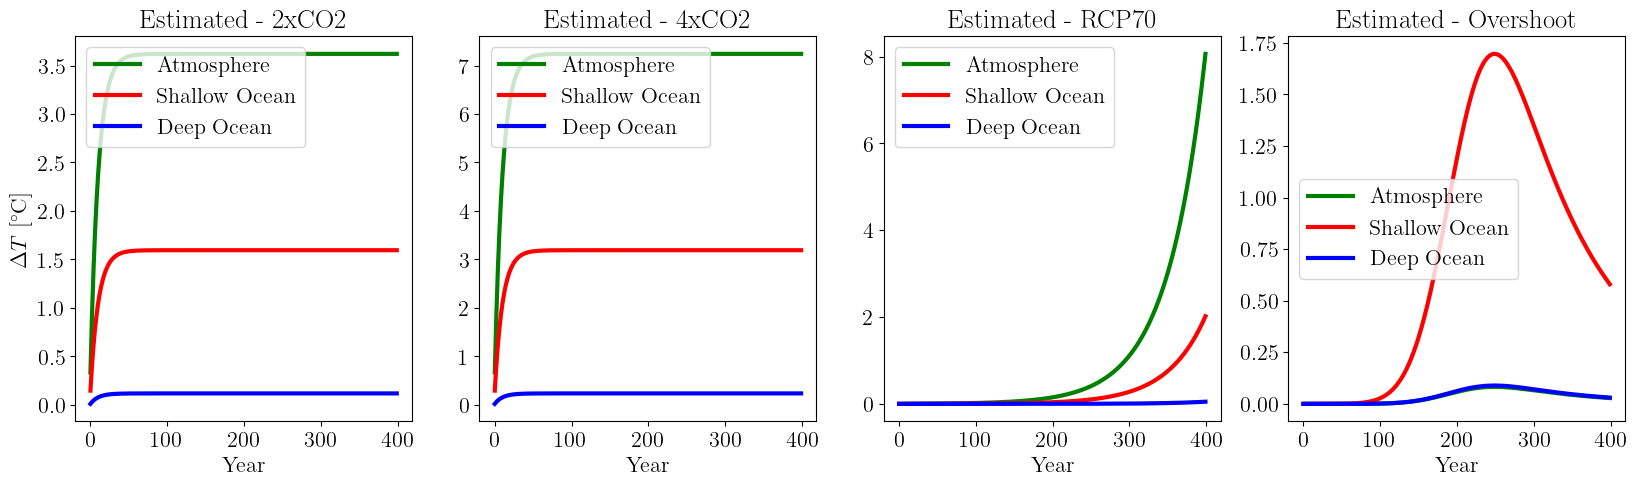

In [8]:
m = 1
k = 3
gamma = np.zeros((3))
gamma[0] = 1.0

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = -np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma, dt)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, None,
                                                      None, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### a.ii) Two leading order timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 13.79044
	L2 Error, 4xCO2: 2.23448
	L2 Error, RCP70: 0.00788
	L2 Error, Overshoot: 17.29991
Avg. L2 Error: 8.33318



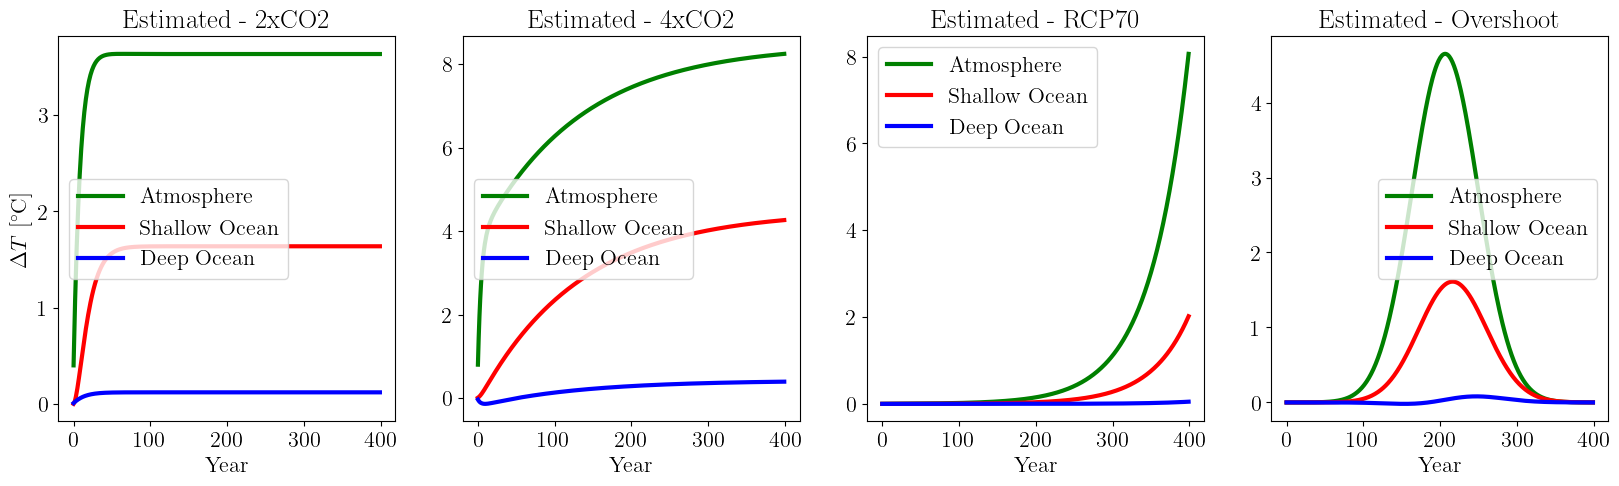

In [16]:
m = 2
k = 3
n_restarts = 10
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

gamma = np.zeros((3))
gamma[0] = 1.0

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = None
  for _ in range(n_restarts):
    initial_v = np.random.rand(m * k)  # Flattened eigenvector
    initial_lam = np.random.rand(m)      # Eigenvalues
    initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
    result = minimize(response_utils.opt_v_lam_2D,
                      initial_params,
                      args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                      method='L-BFGS-B',
                      bounds=bounds)

  if res_raw[exp] is None or result.fun < res_raw[exp].fun:
    res_raw[exp] = result

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma, dt)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, None,
                                                      None, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### a.iii) All timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 14.02491
	L2 Error, 4xCO2: 27.91312
	L2 Error, RCP70: 0.00807
	L2 Error, Overshoot: 0.80833
Avg. L2 Error: 10.6886



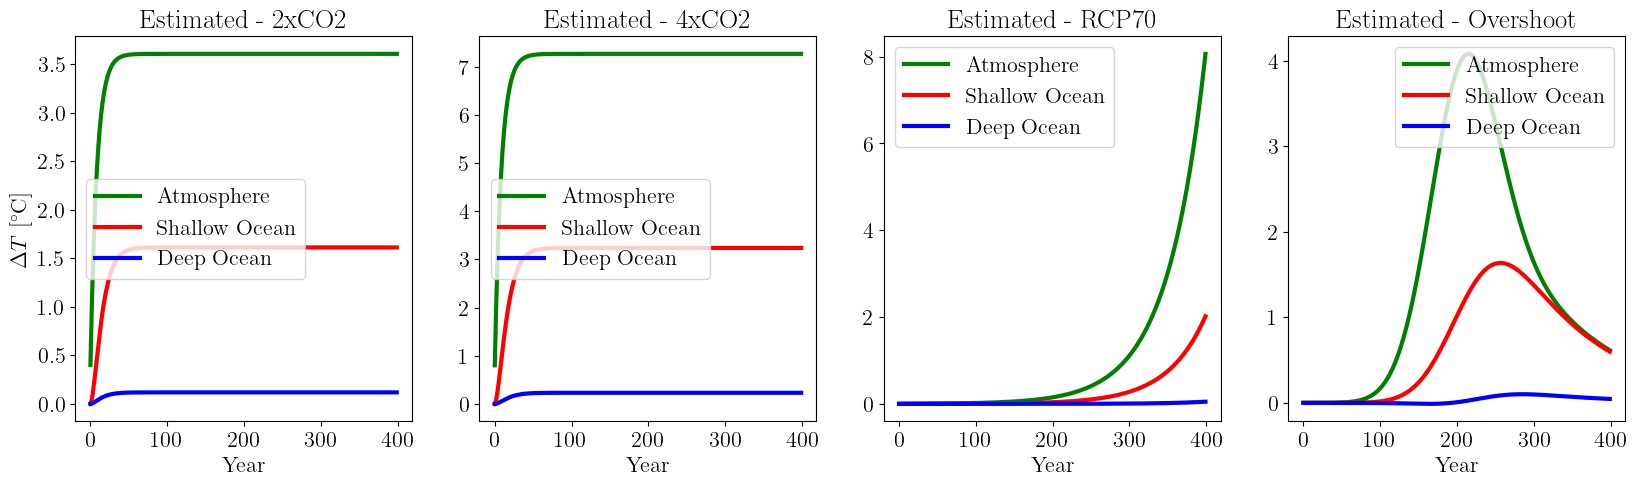

In [153]:
m = 3
k = 3
gamma = np.zeros((3))
gamma[0] = 1.0

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(-1, 1)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma, dt)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, None,
                                                      None, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### b) With noise